# Flight price predicting

## Truncating Data

- initial dataset was way to large (30GB deserialized)
- because the crawler for the data ran every day the initial data has a time-series-component 

### Solutions

-> Look at the amount of crawled entry for each working day, choose date with good amount of entries (2022.05.11)

This way we cut most of the data while also losing the time series component. (2 Fliegen mit einer Klatsche)

*** From now own all further processing and training steps will also account for the new truncated dataset: "searchDate_2022-05.11" ***

Well then lets get to cooking UwU

## Dataset Overhead

This section is for imports, data fetching, first train test split

In [25]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [7]:
# get data
data_raw = pd.read_csv("../data/truncated/searchDate_2022-05-11.csv")

## Data Exploration

basics first

In [10]:
# Create a copy to avoid changing the original raw data
data = data_raw.copy()

# 1. Check the shape (rows, columns)
print("--- Shape of the Data ---")
print(data.shape)
print("\n")

# 2. Look at the first few rows
print("--- First 5 Rows (Head) ---")
print(data.head())
print("\n")

# 3. Get column names, non-null counts, and data types
print("--- Data Info (Columns, Types, Nulls) ---")
print(data.info())
print("\n")

# 4. Get descriptive statistics for numerical columns
print("--- Descriptive Statistics (Numerical) ---")
print(data.describe())
print("\n")

# 5. Get descriptive statistics for categorical/object columns
print("--- Descriptive Statistics (Categorical) ---")
print(data.describe(include=['object']))

--- Shape of the Data ---
(112312, 27)


--- First 5 Rows (Head) ---
                              legId  searchDate  flightDate startingAirport  \
0  d86dda4a2638c7c507860716cbf720bb  2022-05-11  2022-05-12             ATL   
1  dd140eba93e18dfc6b6c46ee0fe4fe79  2022-05-11  2022-05-12             ATL   
2  66fef7e0b6488f3fd4bab4f4e8771a44  2022-05-11  2022-05-12             ATL   
3  bba4406a093dc51af12ff7cc79948908  2022-05-11  2022-05-12             ATL   
4  e5784d82f1850e159091d4f5e815ebed  2022-05-11  2022-05-12             ATL   

  destinationAirport fareBasisCode travelDuration  elapsedDays  \
0                BOS           HNR        PT2H35M            0   
1                BOS      V0AIZNN1        PT4H39M            0   
2                BOS      V0AIZNN1        PT4H44M            1   
3                BOS      V0AIZNN1        PT4H56M            0   
4                BOS      V0AIZNN1         PT6H5M            0   

   isBasicEconomy  isRefundable  ...  segmentsArrivalTimeEp

### Missing Value Analysis and Distributions

--- Missing Value Percentages ---
totalTravelDistance             6.714332
segmentsEquipmentDescription    1.850203
segmentsDistance                0.828941
dtype: float64


--- Analyzing Column Distributions ---

--- 1. Numerical Column Distributions ---


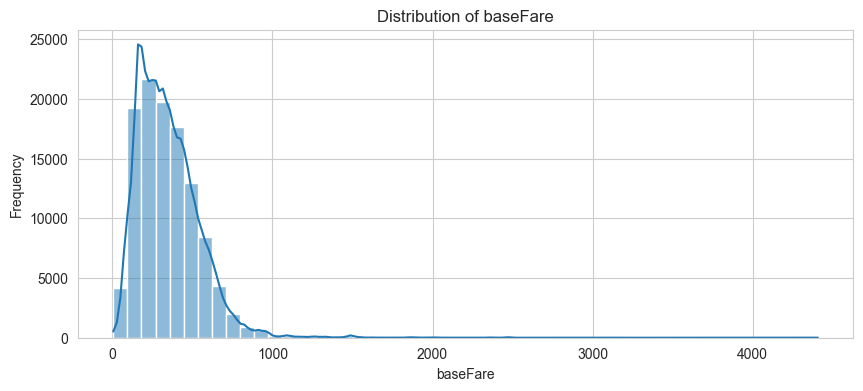

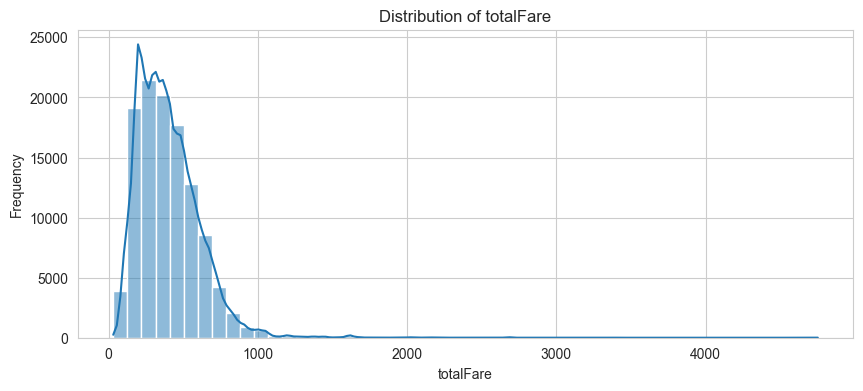

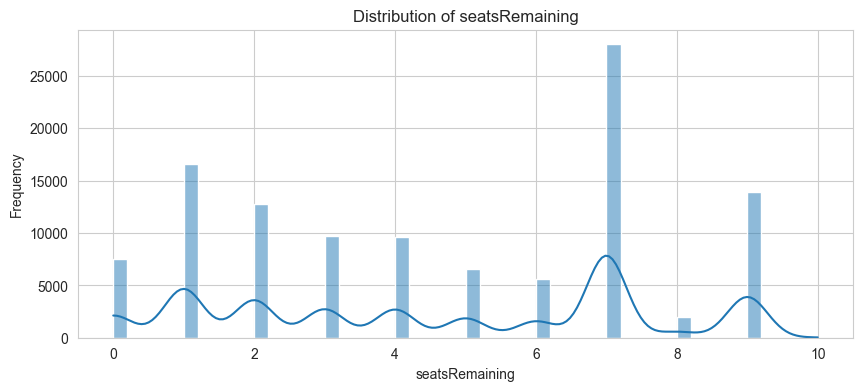

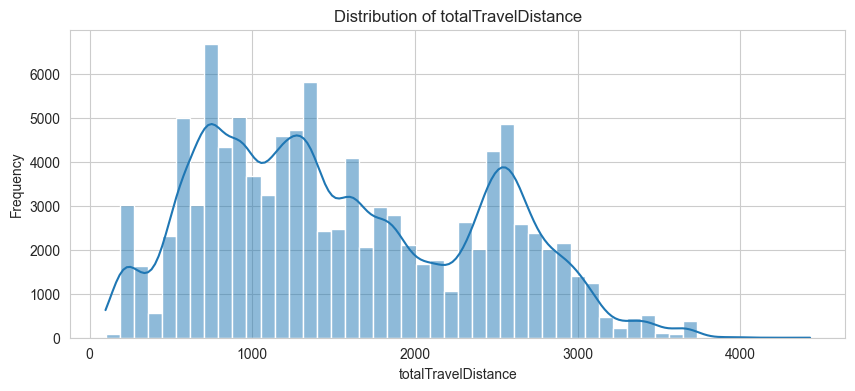

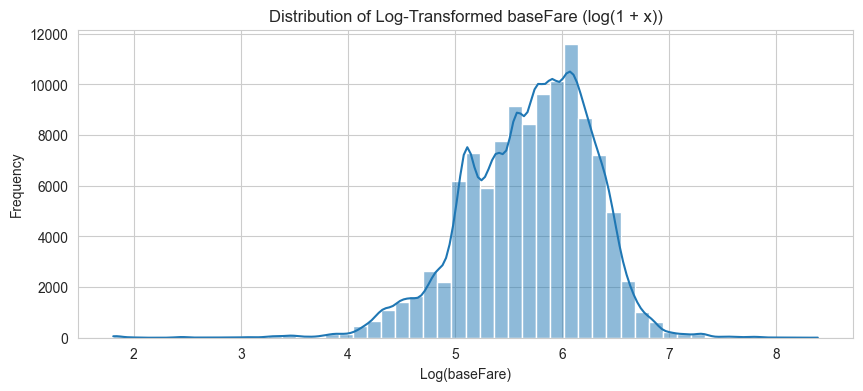


--- 2. Boolean Column Distributions ---


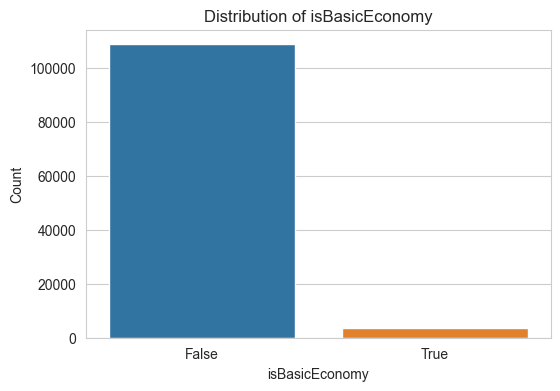

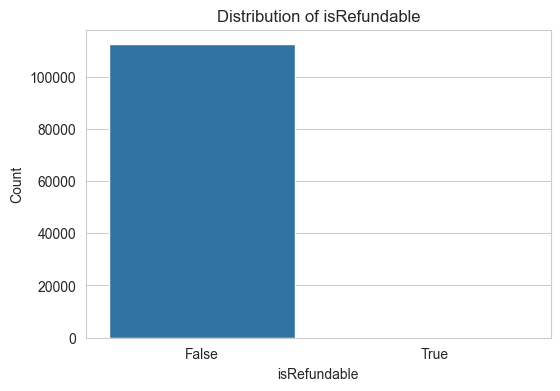

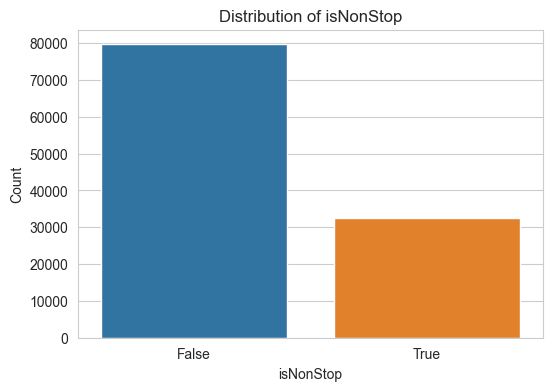


--- 3. Low-Cardinality Categorical Distributions ---


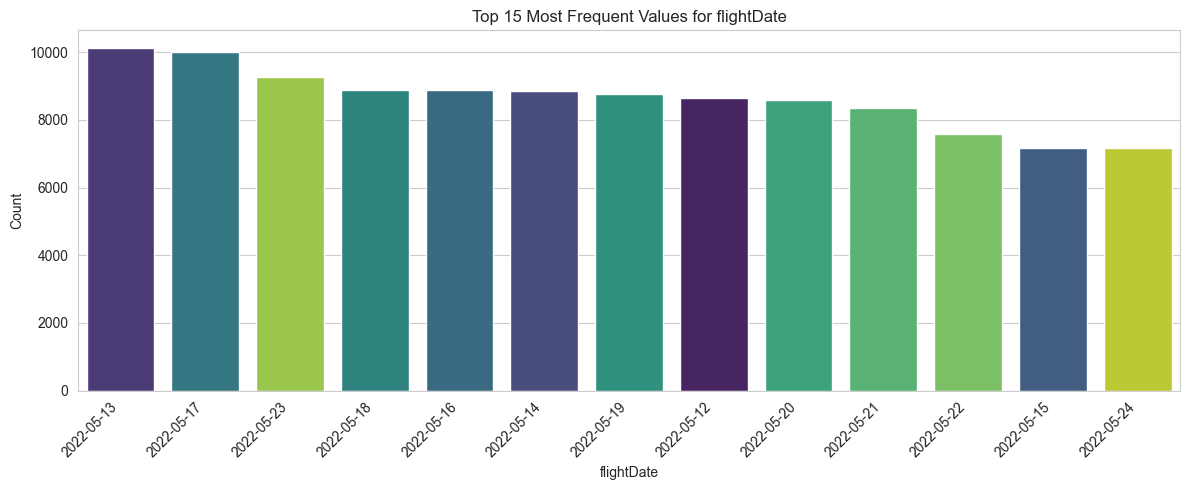

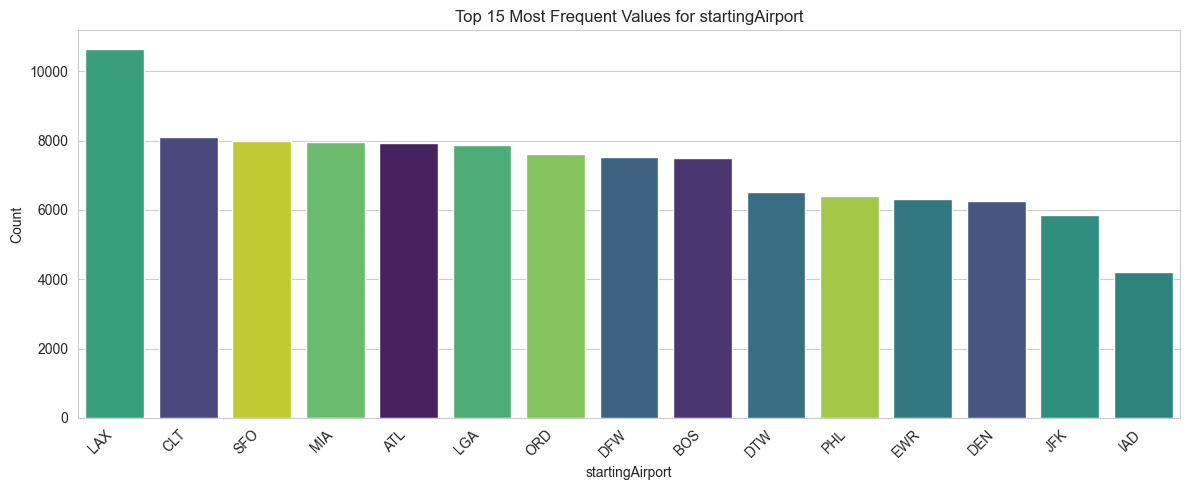

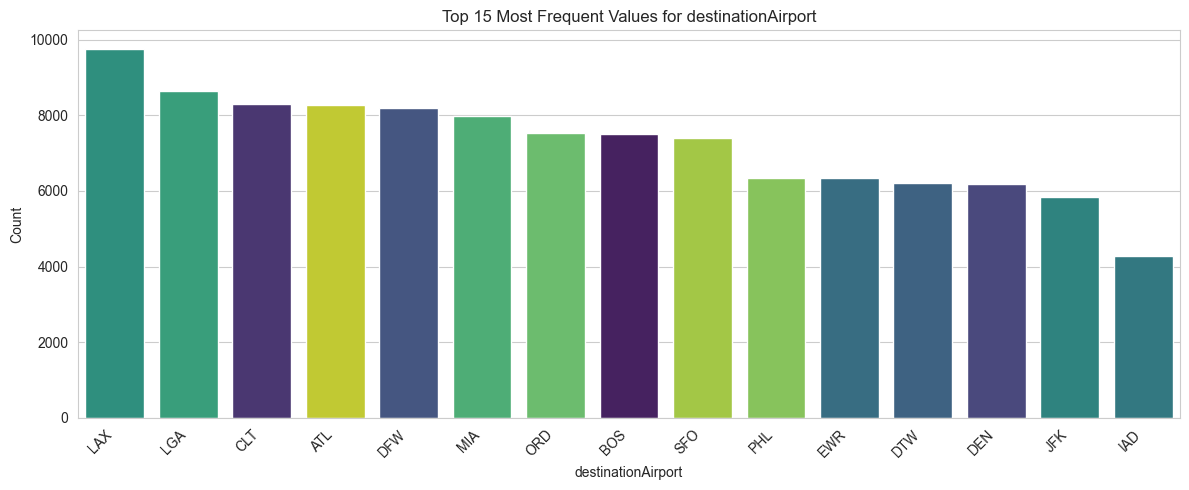

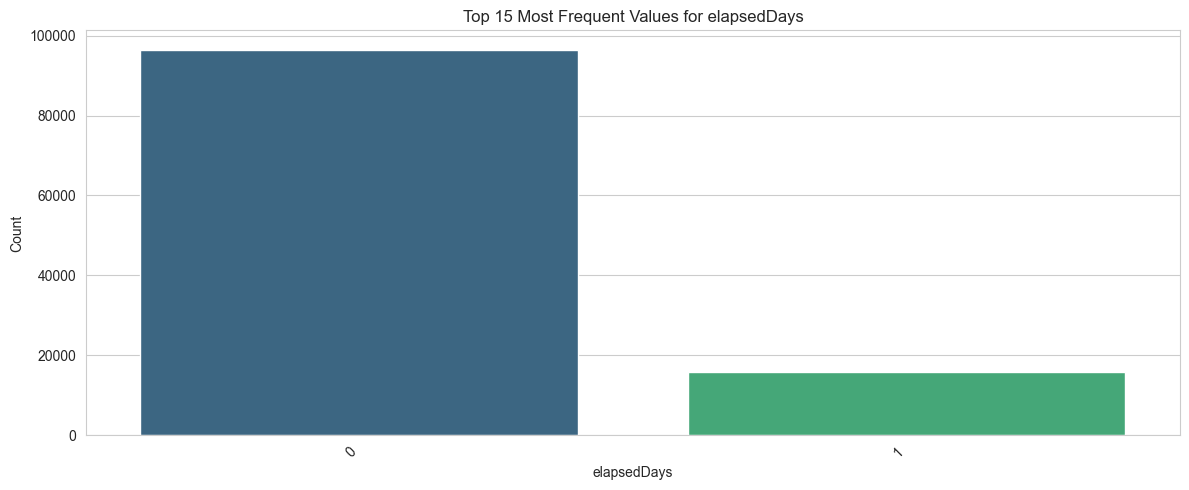

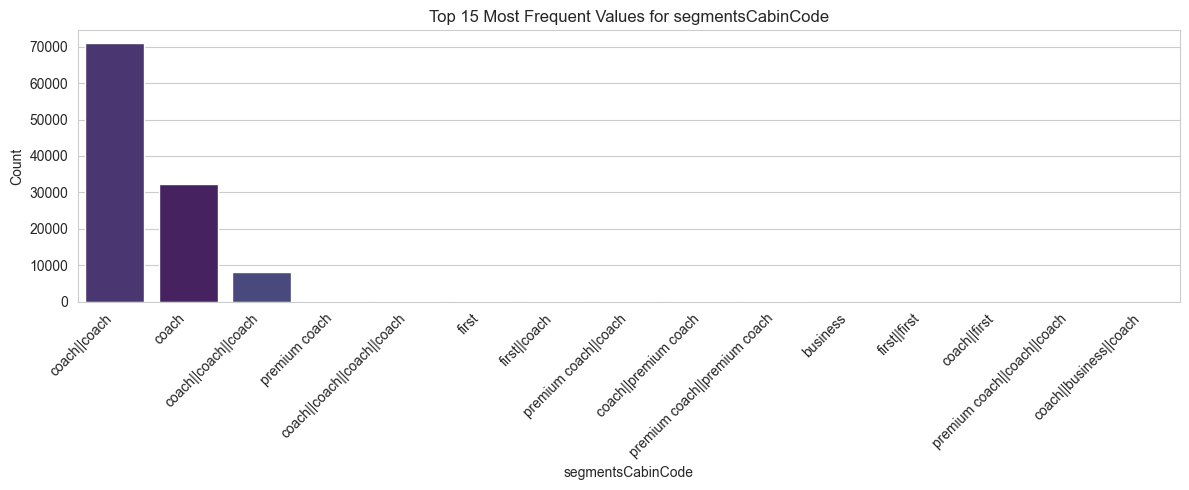

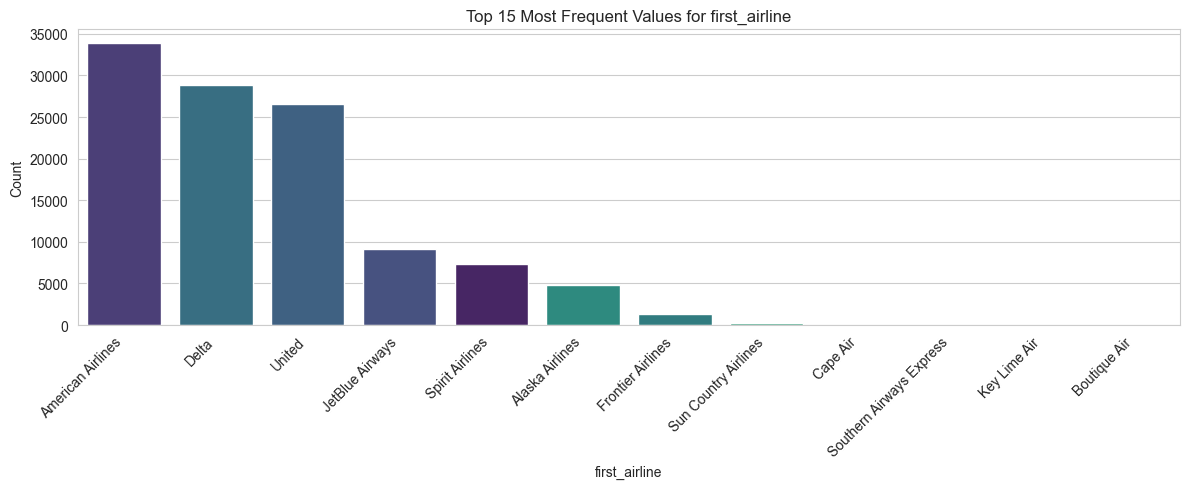


--- 4. High-Cardinality & Identifier Columns (Summary) ---

--- Column: legId ---
  Unique Values: 112312

--- Column: searchDate ---
  Unique Values: 1

--- Column: fareBasisCode ---
  Unique Values: 2021
  Top 5 Most Common Values:
fareBasisCode
QAA0OKEN    2039
YNR         1167
M0AHZNN1    1128
HAA0OKEN    1078
QAA0OFEN     986

--- Column: travelDuration ---
  Unique Values: 1175
  Top 5 Most Common Values:
travelDuration
PT1H25M    459
PT2H4M     443
PT2H       369
PT7H14M    338
PT2H7M     331

--- Column: segmentsDepartureTimeEpochSeconds ---
  Unique Values: 80932
  Top 5 Most Common Values:
segmentsDepartureTimeEpochSeconds
1652868000    59
1653040800    57
1652349600    56
1652954400    56
1652695200    56

--- Column: segmentsDepartureTimeRaw ---
  Unique Values: 87629
  Top 5 Most Common Values:
segmentsDepartureTimeRaw
2022-05-18T06:00:00.000-04:00    56
2022-05-20T06:00:00.000-04:00    53
2022-05-17T06:00:00.000-04:00    52
2022-05-13T06:00:00.000-04:00    52
2022-05-19T

In [22]:
# 1. Calculate and print missing value percentages
print("--- Missing Value Percentages ---")
missing_percent = (data.isnull().sum() / len(data)) * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False))
print("\n")


# Set up a plotting style
sns.set_style("whitegrid")
print("--- Analyzing Column Distributions ---")

# ==============================================================================
# 1. Numerical Columns
# ==============================================================================
print("\n--- 1. Numerical Column Distributions ---")
num_cols = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']

# Plotting histograms for numerical columns
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show() # Show plot

# Also plot log-transformed version for skewed currency data
plt.figure(figsize=(10, 4))
sns.histplot(np.log1p(data['baseFare']), kde=True, bins=50)
plt.title('Distribution of Log-Transformed baseFare (log(1 + x))')
plt.xlabel('Log(baseFare)')
plt.ylabel('Frequency')
plt.show() # Show plot


# ==============================================================================
# 2. Boolean Columns
# ==============================================================================
print("\n--- 2. Boolean Column Distributions ---")
bool_cols = ['isBasicEconomy', 'isRefundable', 'isNonStop']

for col in bool_cols:
    plt.figure(figsize=(6, 4))
    # --- Fix for FutureWarning ---
    sns.countplot(
        data=data,
        x=col,
        hue=col,       # Assign x to hue
        legend=False   # Disable legend
    )
    # --- End of Fix ---
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show() # Show plot

# ==============================================================================
# 3. Low-Cardinality Categorical Columns
# ==============================================================================
print("\n--- 3. Low-Cardinality Categorical Distributions ---")

# A helper function to plot top N categories
def plot_top_n(column_name, n=15):
    plt.figure(figsize=(12, 5))
    
    # Get top N value counts
    top_n = data[column_name].value_counts().nlargest(n).index
    
    # Filter data to only include top N for plotting
    data_to_plot = data[data[column_name].isin(top_n)]
    
    # --- Fix for FutureWarning ---
    sns.countplot(
        data=data_to_plot,          # Pass the filtered dataframe
        x=column_name,              # Pass the column name as a string
        order=top_n,                # Keep the order
        hue=column_name,            # Assign the column name to hue
        palette="viridis",
        legend=False                # Disable the legend as suggested
    )
    # --- End of Fix ---
    
    plt.title(f'Top {n} Most Frequent Values for {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show() # Show plot
    
# Columns to plot
low_card_cols = [
    'flightDate',
    'startingAirport',
    'destinationAirport',
    'elapsedDays', # Treating as categorical since it's just 0 or 1
    'segmentsCabinCode' # Has 31 unique, let's see top 15
]

for col in low_card_cols:
    plot_top_n(col, n=15)

# Special case: segmentsAirlineName - need to split first
# We'll just look at the *first* airline for simplicity
data['first_airline'] = data['segmentsAirlineName'].apply(lambda x: x.split('||')[0])
plot_top_n('first_airline', n=15)


# ==============================================================================
# 4. High-Cardinality & Identifier Columns
# ==============================================================================
print("\n--- 4. High-Cardinality & Identifier Columns (Summary) ---")
# These columns are not suitable for plotting. We'll print their unique counts
# and the top 5 most frequent values.

high_card_cols = [
    'legId',
    'searchDate',
    'fareBasisCode',
    'travelDuration',
    'segmentsDepartureTimeEpochSeconds',
    'segmentsDepartureTimeRaw',
    'segmentsArrivalTimeEpochSeconds',
    'segmentsArrivalTimeRaw',
    'segmentsArrivalAirportCode',
    'segmentsDepartureAirportCode',
    'segmentsAirlineCode',
    'segmentsEquipmentDescription',
    'segmentsDurationInSeconds',
    'segmentsDistance'
]

for col in high_card_cols:
    print(f"\n--- Column: {col} ---")
    num_unique = data[col].nunique()
    print(f"  Unique Values: {num_unique}")

    # Don't print value counts for IDs like legId
    if num_unique == len(data) or num_unique == 1:
        continue
    
    print("  Top 5 Most Common Values:")
    print(data[col].value_counts().head(5).to_string())


print("\n--- Distribution analysis complete ---")

### Outlier Analysis


--- Starting Outlier Analysis ---
--- 1. Box Plot Analysis (Fix Applied) ---


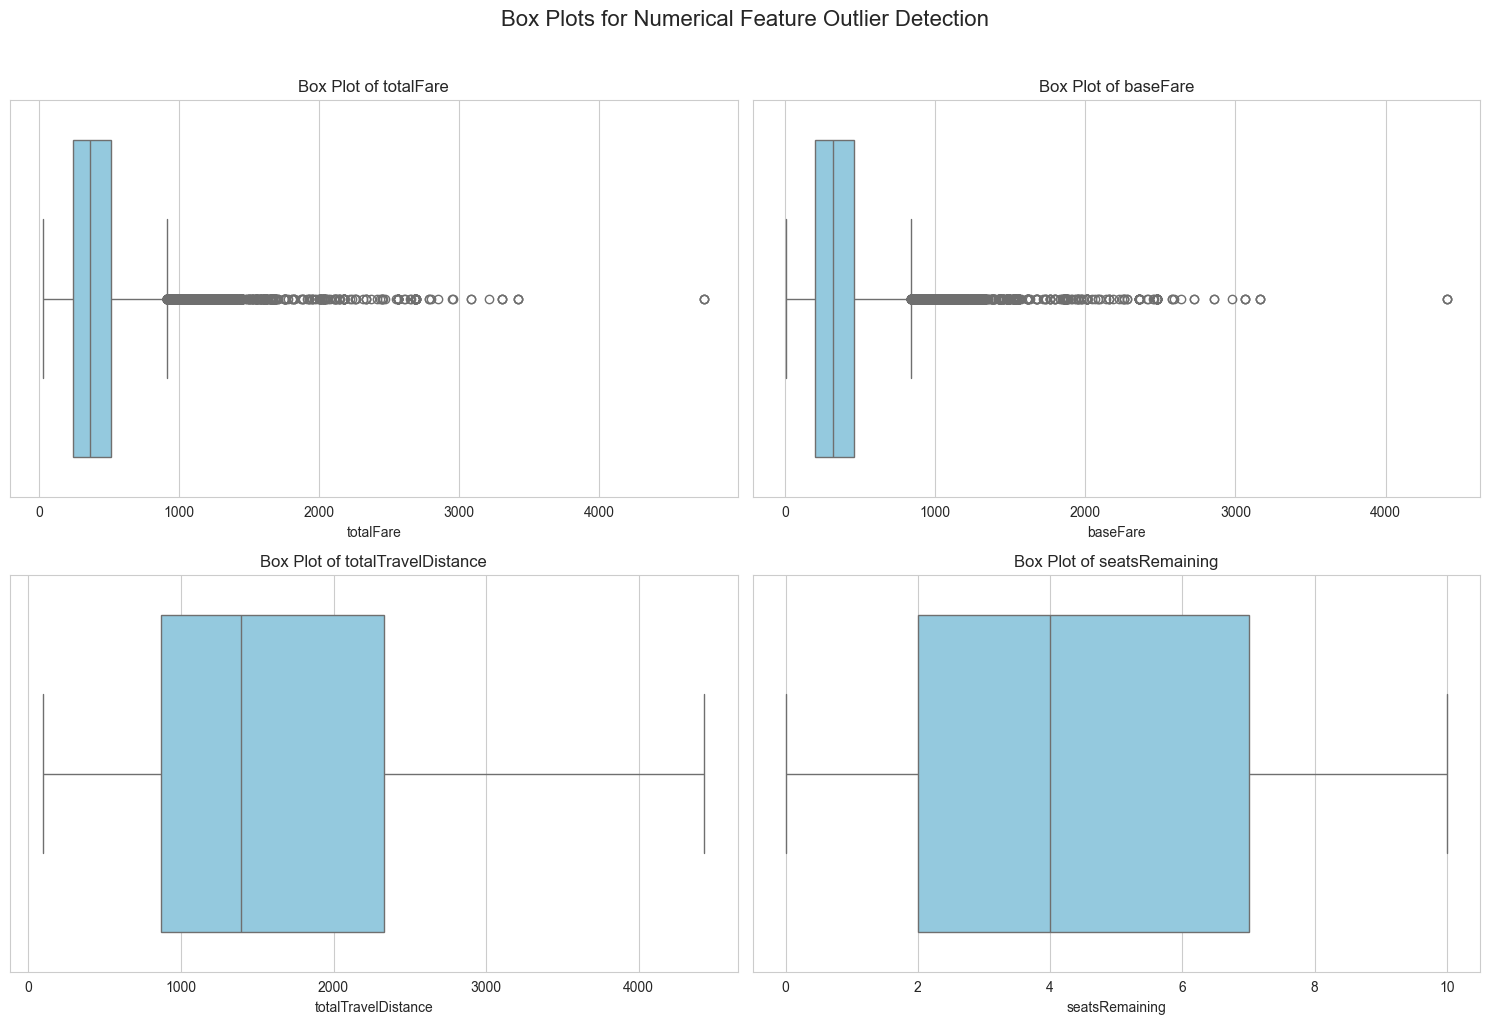


--- Top 5 Most Expensive Flights (Outliers) ---
       totalFare startingAirport destinationAirport  isNonStop
34589    4752.60             SFO                JFK       True
95655    4752.60             SFO                JFK       True
49094    4752.60             JFK                SFO       True
31378    3419.33             JFK                MIA      False
31377    3418.25             JFK                MIA      False


--- 2. Clustering Outliers with DBSCAN ---
Original data points: 112312, After dropping NaNs: 104771


/var/folders/vs/nb76g0hj0cg_x9_317mhxw880000gn/T/ipykernel_27885/1159737976.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data_clean['cluster'] = clusters



Cluster membership counts (DBSCAN):
cluster
 0    104336
-1       311
 1       124
Name: count, dtype: int64


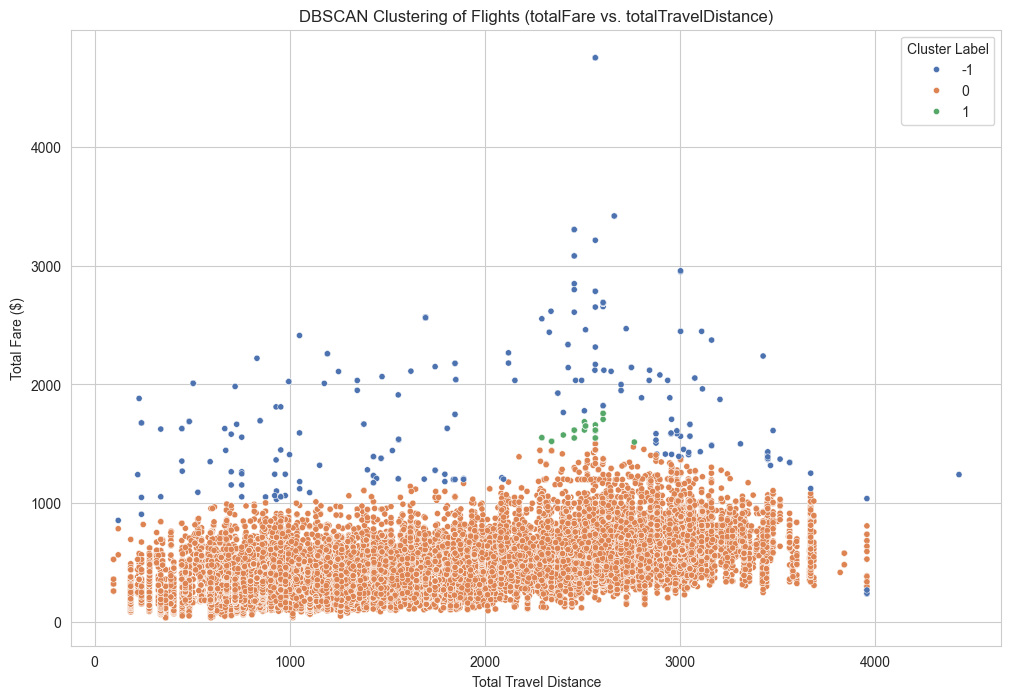

--- Outlier analysis complete ---


In [30]:
print("\n--- Starting Outlier Analysis ---")
print("--- 1. Box Plot Analysis (Fix Applied) ---")

# We can reuse the numerical columns list
num_cols = ['totalFare', 'baseFare', 'totalTravelDistance', 'seatsRemaining']

# Set up the plotting figure (2 rows, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Box Plots for Numerical Feature Outlier Detection', fontsize=16, y=1.02)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate a boxplot for each numerical column
for i, col in enumerate(num_cols):
    
    # --- FIX ---
    # Replaced 'palette="pastel"' with a single 'color'
    # This avoids the palette/hue conflict and the warning.
    sns.boxplot(
        data=data,
        x=col,
        ax=axes[i], # Assign plot to the correct subplot
        color='skyblue' # Use a single color
    )
    # --- End of Fix ---
    
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_xlabel(col)

# Adjust layout
plt.tight_layout()
plt.show()

# --- Deeper look at totalFare outliers ---
print("\n--- Top 5 Most Expensive Flights (Outliers) ---")
# Sort by 'totalFare' to see the most extreme examples
print(data.sort_values('totalFare', ascending=False)[['totalFare', 'startingAirport', 'destinationAirport', 'isNonStop']].head())


print("\n\n--- 2. Clustering Outliers with DBSCAN ---")

# --- a. Select & Clean data for clustering ---
# We'll cluster on two key features
cluster_features = ['totalFare', 'totalTravelDistance']
cluster_data = data[cluster_features].copy()

# DBSCAN cannot handle missing values, so we must drop them
cluster_data_clean = cluster_data.dropna()
print(f"Original data points: {len(cluster_data)}, After dropping NaNs: {len(cluster_data_clean)}")

# --- b. Scale the features ---
# This is critical for distance-based algorithms like DBSCAN
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data_clean)

# --- c. Run DBSCAN ---
# We set 'eps' (max distance) and 'min_samples'
# A low 'eps' and high 'min_samples' will find only very dense clusters
# 'min_samples=50' is a good starting point for a large dataset
db = DBSCAN(eps=0.35, min_samples=50)
clusters = db.fit_predict(cluster_data_scaled)

# Add cluster labels back to our clean data
cluster_data_clean['cluster'] = clusters
# Label -1 is "noise" (i.e., outliers). Other labels (0, 1, 2...) are "core" clusters.
print("\nCluster membership counts (DBSCAN):")
print(cluster_data_clean['cluster'].value_counts())


# --- d. Plot the clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=cluster_data_clean,
    x='totalTravelDistance',
    y='totalFare',
    hue='cluster', # Color by the cluster label
    palette="deep",
    s=20 # Make points smaller to see patterns
)
plt.title('DBSCAN Clustering of Flights (totalFare vs. totalTravelDistance)')
plt.xlabel('Total Travel Distance')
plt.ylabel('Total Fare ($)')
plt.legend(title='Cluster Label')
plt.show()

print("--- Outlier analysis complete ---")

### Non-Numerical Features

--- Running necessary Feature Engineering ---
Engineered 'num_segments', 'totalFare_log', and 'first_airline'.

--- 1. Categorical vs. Categorical: Airline vs. Basic Economy ---
isBasicEconomy            False  True 
first_airline                         
Alaska Airlines            4760    100
American Airlines         33263    577
Cape Air                     59      0
Delta                     26700   2129
Frontier Airlines          1382      0
JetBlue Airways            9109      0
Southern Airways Express     42      0
Spirit Airlines            7354      0
Sun Country Airlines        203      0
United                    25807    769


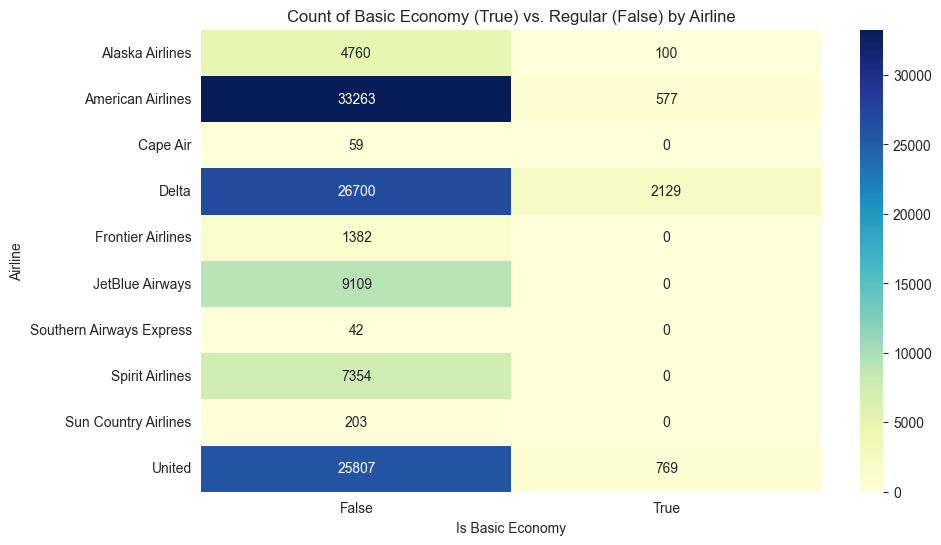


--- 2. Multivariate: Price vs. Segments, grouped by Basic Economy ---


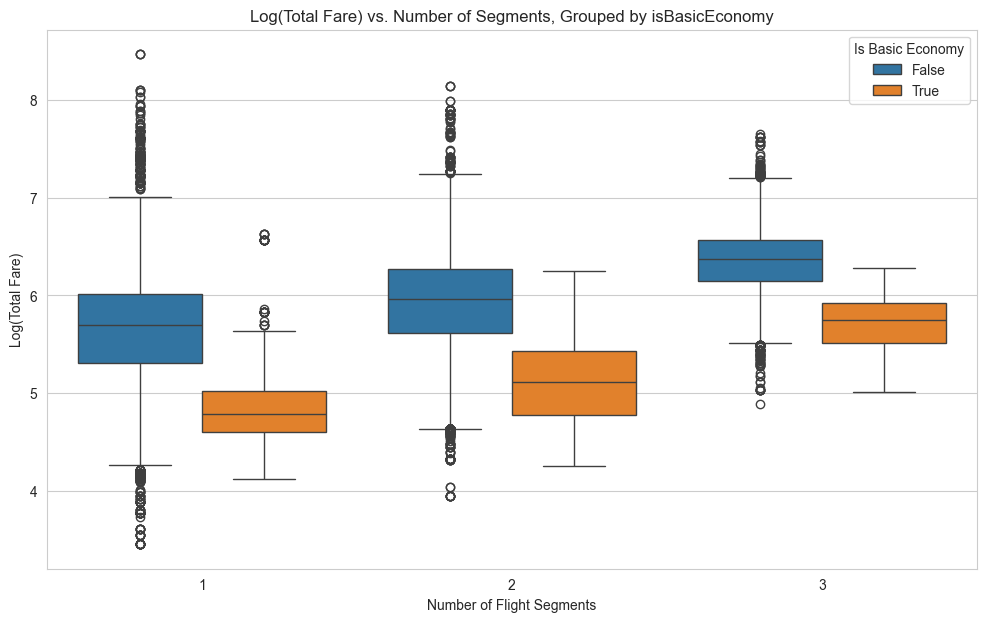

In [33]:
# ==============================================================================
# 1. Feature Engineering (This was the missing part)
# ==============================================================================
print("--- Running necessary Feature Engineering ---")

# a. 'num_segments'
data['num_segments'] = data['segmentsAirlineName'].apply(lambda x: len(x.split('||')))

# b. 'totalFare_log'
data['totalFare_log'] = np.log1p(data['totalFare'])

# c. 'first_airline'
data['first_airline'] = data['segmentsAirlineName'].apply(lambda x: x.split('||')[0])

print("Engineered 'num_segments', 'totalFare_log', and 'first_airline'.")


# ==============================================================================
# 2. Categorical vs. Categorical Analysis
# ==============================================================================
print("\n--- 1. Categorical vs. Categorical: Airline vs. Basic Economy ---")

# Let's get the top 10 airlines to keep the plot clean
top_10_airlines = data['first_airline'].value_counts().nlargest(10).index
data_top_10 = data[data['first_airline'].isin(top_10_airlines)]

# Create a cross-tabulation
airline_vs_basic = pd.crosstab(
    data_top_10['first_airline'],
    data_top_10['isBasicEconomy']
)

print(airline_vs_basic)

# Plot this as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    airline_vs_basic,
    annot=True,     # Show the counts
    fmt='d',        # Format as integers
    cmap="YlGnBu"
)
plt.title('Count of Basic Economy (True) vs. Regular (False) by Airline')
plt.xlabel('Is Basic Economy')
plt.ylabel('Airline')
plt.show()

# ==============================================================================
# 3. Multivariate Analysis (Cat + Cat vs. Num Target)
# ==============================================================================
print("\n--- 2. Multivariate: Price vs. Segments, grouped by Basic Economy ---")

# Let's look at flights with 1, 2, or 3 segments
data_segments_123 = data[data['num_segments'].isin([1, 2, 3])]

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=data_segments_123,
    x='num_segments',
    y='totalFare_log',
    hue='isBasicEconomy' # This is the key! It creates the groups.
)
plt.title('Log(Total Fare) vs. Number of Segments, Grouped by isBasicEconomy')
plt.xlabel('Number of Flight Segments')
plt.ylabel('Log(Total Fare)')
plt.legend(title='Is Basic Economy')
plt.show()

## Feature Engineering